# Object Classification Using Convolutional Neural Networks
## Pen vs. Pencil Classification

**Objective:** Develop a CNN model that automatically classifies images into two categories: pen and pencil.

---

## Learning Objectives
- Understand the fundamentals of image classification using CNNs
- Prepare and preprocess an image dataset for deep learning
- Design and implement a simple CNN model
- Train, validate, and evaluate a CNN for binary classification
- Analyze model performance using accuracy and loss metrics

## Part 1: Data Preparation and Setup

In this section, we will:
1. Install required libraries
2. Load the image dataset
3. Preprocess images (resize to 128×128 and normalize)
4. Split data into training and validation sets (80/20 split)

In [10]:

#Import Required Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from pathlib import Path
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
GPU Available: []


### Step 1: Create Dataset Structure

If you don't have a dataset, you can:
- Download sample images from an open-source repository
- Create synthetic data
- Use a pre-existing dataset

**Expected folder structure:**
```
dataset/
├── pen/
│   ├── pen1.jpg
│   ├── pen2.jpg
│   └── ...
└── pencil/
    ├── pencil1.jpg
    ├── pencil2.jpg
    └── ...
```

For this demonstration, we'll create a function to load images from your dataset directory.

In [11]:
# Configuration
DATASET_PATH = "C:/Users/ASUS/OneDrive/Desktop/dataset"  # Change this to your dataset directory
IMAGE_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 15
VALIDATION_SPLIT = 0.2

# Create sample dataset structure (for demonstration)
# If you have your own dataset, modify DATASET_PATH accordingly
def create_sample_dataset_structure():
    """Create sample folder structure for dataset"""
    os.makedirs(os.path.join(DATASET_PATH, "pen"), exist_ok=True)
    os.makedirs(os.path.join(DATASET_PATH, "pencil"), exist_ok=True)
    print(f"Dataset structure created at: {DATASET_PATH}")

# Uncomment the line below if you need to create folder structure
# create_sample_dataset_structure()

### Step 2: Load and Preprocess Images

We'll create functions to:
- Load images from directories
- Resize to 128×128 pixels
- Normalize pixel values to [0, 1]
- Create labels for each class

In [12]:
def load_images_from_directory(directory, label, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
    """
    Load images from a directory and return arrays of images and labels
    
    Parameters:
    - directory: path to folder containing images
    - label: binary label (0 for pen, 1 for pencil)
    - target_size: size to resize images to
    
    Returns:
    - images: array of preprocessed images
    - labels: array of corresponding labels
    """
    images = []
    labels = []
    
    # Check if directory exists
    if not os.path.exists(directory):
        print(f"Warning: Directory {directory} does not exist")
        return np.array(images), np.array(labels)
    
    # Get list of image files
    image_files = [f for f in os.listdir(directory) 
                   if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
    
    print(f"Loading {len(image_files)} images from {directory}...")
    
    for img_file in tqdm(image_files):
        try:
            img_path = os.path.join(directory, img_file)
            # Load and resize image
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                img = cv2.resize(img, target_size)
                # Normalize pixel values to [0, 1]
                img = img.astype('float32') / 255.0
                images.append(img)
                labels.append(label)
        except Exception as e:
            print(f"Error loading {img_file}: {str(e)}")
    
    return np.array(images), np.array(labels)

# Load pen images (label = 0)
pen_images, pen_labels = load_images_from_directory(
    os.path.join(DATASET_PATH, "pen"), 
    label=0
)

# Load pencil images (label = 1)
pencil_images, pencil_labels = load_images_from_directory(
    os.path.join(DATASET_PATH, "pencil"), 
    label=1
)

# Combine all images and labels
all_images = np.concatenate([pen_images, pencil_images])
all_labels = np.concatenate([pen_labels, pencil_labels])

print(f"\nTotal images loaded: {len(all_images)}")
print(f"Pen images: {len(pen_images)}")
print(f"Pencil images: {len(pencil_images)}")
print(f"Image shape: {all_images[0].shape if len(all_images) > 0 else 'No images'}")

Loading 40 images from C:/Users/ASUS/OneDrive/Desktop/dataset\pen...


100%|██████████| 40/40 [00:04<00:00,  9.63it/s]


Loading 40 images from C:/Users/ASUS/OneDrive/Desktop/dataset\pencil...


100%|██████████| 40/40 [00:04<00:00,  8.18it/s]


Total images loaded: 80
Pen images: 40
Pencil images: 40
Image shape: (128, 128, 3)


### Step 3: Split Dataset into Training and Validation Sets

We'll split the data with:
- 80% for training
- 20% for validation

In [13]:
# Split data into training and validation sets (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    all_images, 
    all_labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=all_labels
)

print(f"Training set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")
print(f"\nTraining labels - Pen: {np.sum(y_train == 0)}, Pencil: {np.sum(y_train == 1)}")
print(f"Validation labels - Pen: {np.sum(y_val == 0)}, Pencil: {np.sum(y_val == 1)}")

Training set: 64 images
Validation set: 16 images

Training labels - Pen: 32, Pencil: 32
Validation labels - Pen: 8, Pencil: 8


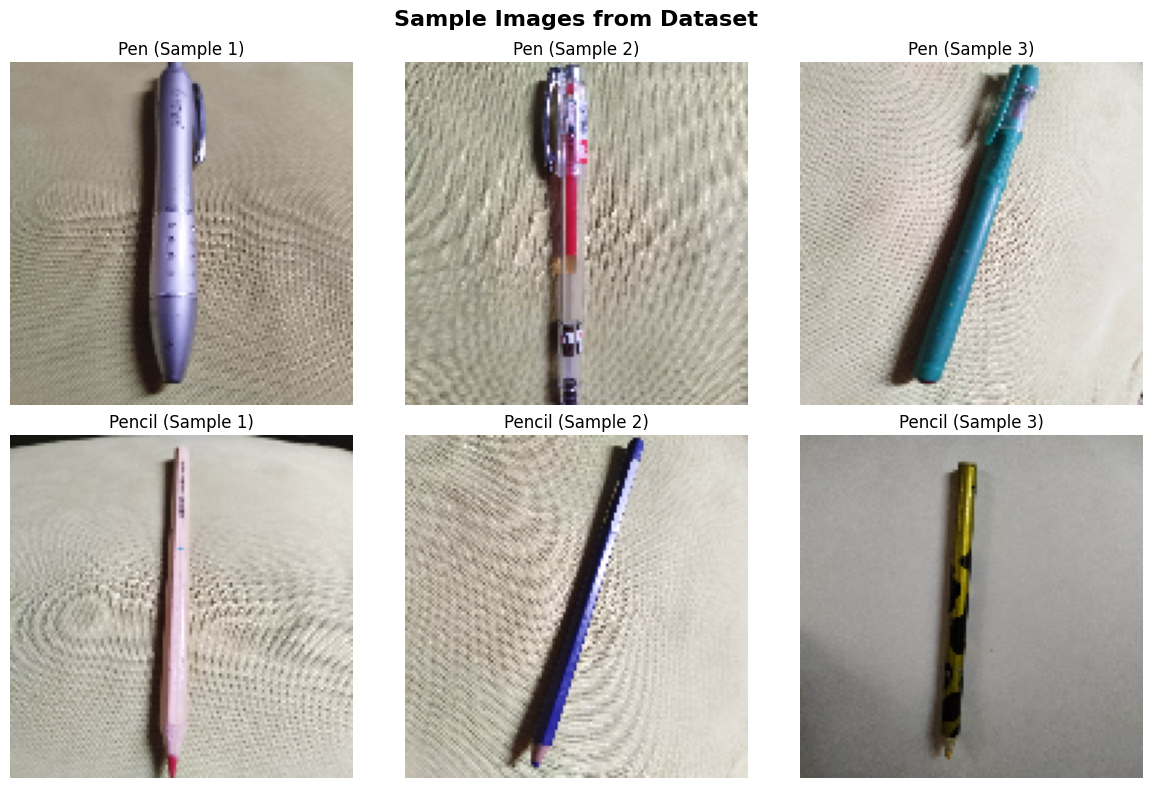

Dataset preparation complete!


In [14]:
# Visualize sample images from the dataset
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Sample Images from Dataset', fontsize=16, fontweight='bold')

class_names = ['Pen', 'Pencil']

# Show 3 pen images and 3 pencil images
for i in range(3):
    pen_idx = np.where(y_train == 0)[0][i] if np.sum(y_train == 0) > i else 0
    pencil_idx = np.where(y_train == 1)[0][i] if np.sum(y_train == 1) > i else 0
    
    axes[0, i].imshow(X_train[pen_idx])
    axes[0, i].set_title(f'{class_names[0]} (Sample {i+1})')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(X_train[pencil_idx])
    axes[1, i].set_title(f'{class_names[1]} (Sample {i+1})')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("Dataset preparation complete!")

---

## Part 2: CNN Model Design

We'll build a Convolutional Neural Network with the following architecture:

- **Input Layer:** 128 × 128 × 3
- **Convolution Layer 1:** 32 filters, 3×3 kernel + ReLU activation
- **Max Pooling Layer 1:** 2×2 pool size
- **Convolution Layer 2:** 64 filters, 3×3 kernel + ReLU activation
- **Max Pooling Layer 2:** 2×2 pool size
- **Flatten Layer:** Convert 2D feature maps to 1D vector
- **Dense Layer (Fully Connected):** 128 units + ReLU activation
- **Dropout Layer:** 0.5 dropout rate (regularization)
- **Output Layer:** 1 unit with Sigmoid activation (binary classification)

In [15]:
# Build the CNN Model
def create_cnn_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)):
    """
    Create a CNN model for binary classification (Pen vs Pencil)
    """
    model = models.Sequential([
        # First Convolution Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        # Second Convolution Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Third Convolution Block (Additional for better feature extraction)
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten Layer
        layers.Flatten(),
        
        # Fully Connected Layers
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Regularization to prevent overfitting
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        
        # Output Layer for Binary Classification
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Create the model
model = create_cnn_model()

# Display model architecture
print("=" * 60)
print("CNN MODEL ARCHITECTURE")
print("=" * 60)
model.summary()

CNN MODEL ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,670,401 (6.37 MB)

 Trainable params: 1,670,401 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

---

## Part 3: Model Compilation and Training

We'll compile the model with:
- **Optimizer:** Adam (adaptive learning rate optimizer)
- **Loss Function:** Binary Crossentropy (for binary classification)
- **Metric:** Accuracy

In [16]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")
print(f"Optimizer: Adam")
print(f"Loss Function: Binary Crossentropy")
print(f"Metrics: Accuracy")

Model compiled successfully!
Optimizer: Adam
Loss Function: Binary Crossentropy
Metrics: Accuracy


### Train the Model

The model will be trained for 15 epochs with:
- Batch size: 32
- Validation split: 20% of training data

In [17]:
# Check if we have data to train
if len(X_train) > 0:
    # Train the model
    print("Training the CNN model...")
    print("=" * 60)
    
    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        verbose=1
    )
    
    print("=" * 60)
    print("Training completed!")
else:
    print("No training data available. Please add images to the dataset folder.")
    history = None

Training the CNN model...
Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 866ms/step - accuracy: 0.5000 - loss: 0.7238 - val_accuracy: 0.5000 - val_loss: 0.6948
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 461ms/step - accuracy: 0.3594 - loss: 0.7468 - val_accuracy: 0.5000 - val_loss: 0.6940
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step - accuracy: 0.5000 - loss: 0.6865 - val_accuracy: 0.5000 - val_loss: 0.6918
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 446ms/step - accuracy: 0.3906 - loss: 0.7069 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.5469 - loss: 0.6912 - val_accuracy: 0.5000 - val_loss: 0.6974
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step - accuracy: 0.4219 - loss: 0.7059 - val_accuracy: 0.5000 - val_loss: 0.6923
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step - accuracy: 0.4531 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.6895
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step - accuracy: 0.4375 - loss: 0.6961 - val_ac

---

## Part 4: Model Evaluation and Analysis

### Plot Training and Validation Metrics

Visualize the training and validation accuracy and loss over epochs.

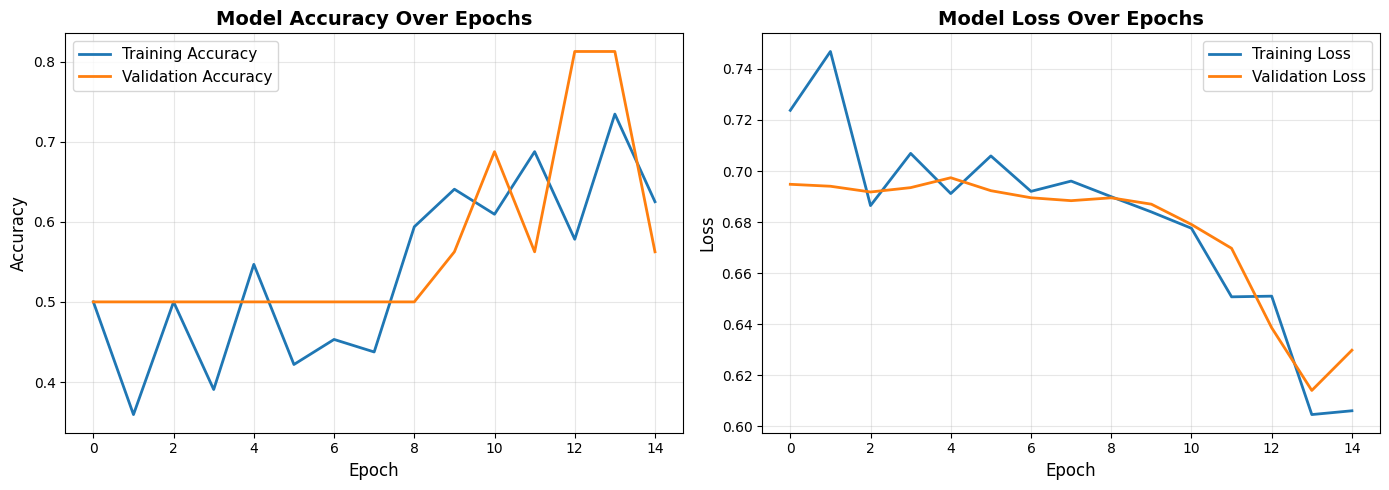

Training and validation metrics plotted successfully!


In [18]:
# Plot training and validation accuracy and loss
if history is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot Accuracy
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Plot Loss
    axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Training and validation metrics plotted successfully!")
else:
    print("No training history available. Train the model first.")

### Evaluate Model Performance on Validation Set

In [19]:
# Evaluate the model on validation set
if len(X_val) > 0:
    print("=" * 60)
    print("MODEL EVALUATION ON VALIDATION SET")
    print("=" * 60)
    
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    
    print(f"\nValidation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
    print("=" * 60)
else:
    print("No validation data available.")

MODEL EVALUATION ON VALIDATION SET

Validation Loss: 0.6298
Validation Accuracy: 0.5625 (56.25%)


### Make Predictions on Sample Images

Generate predictions for sample validation images with confidence scores.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


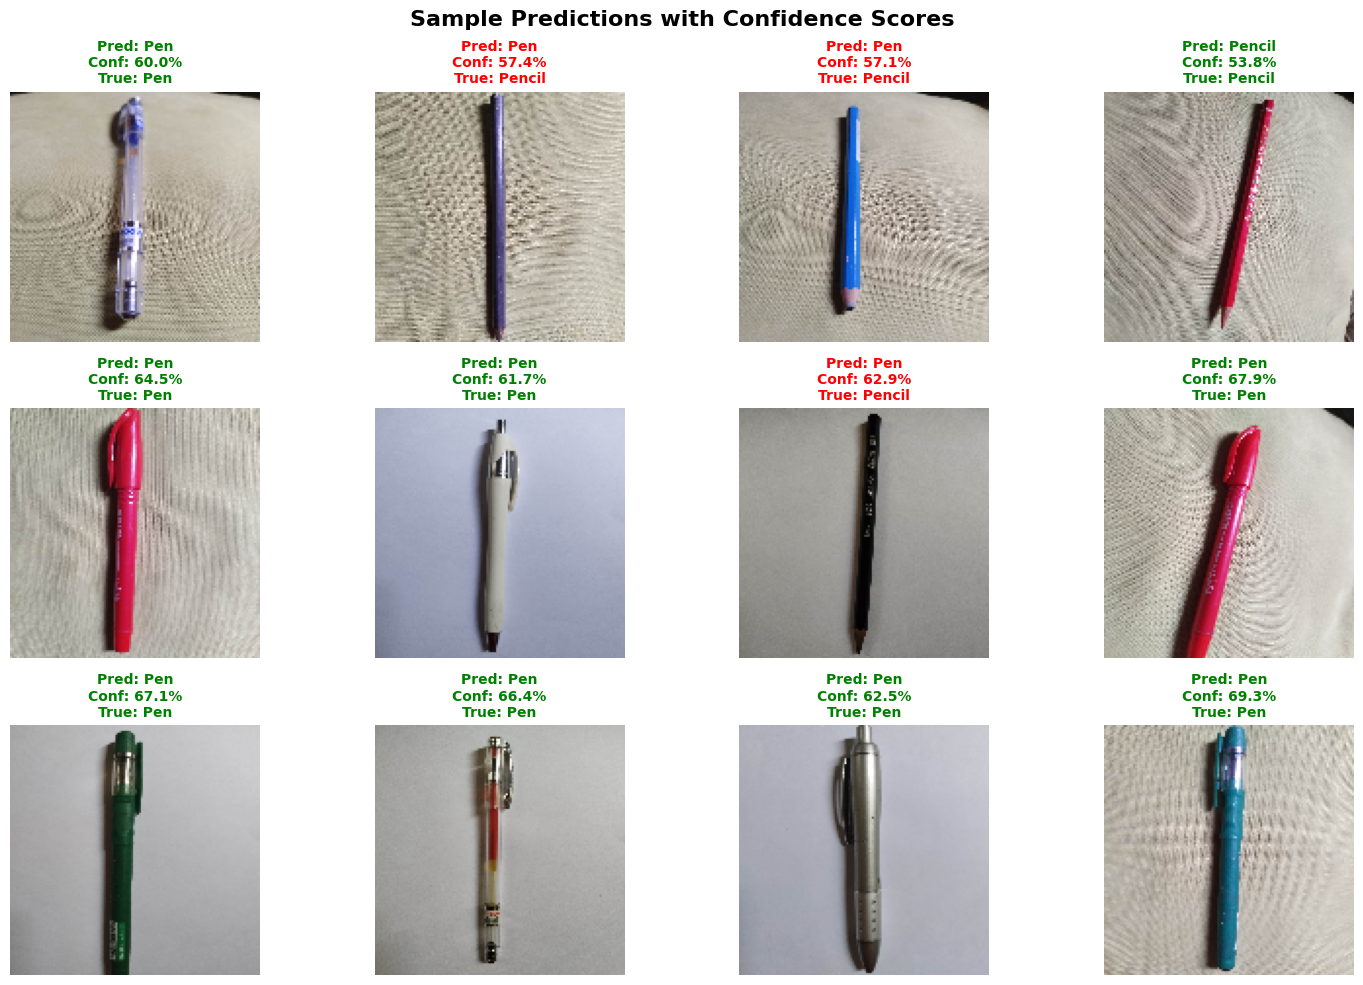


Correct predictions (sample): 9/12


In [20]:
# Make predictions on sample validation images
if len(X_val) > 0:
    # Get predictions for all validation images
    predictions = model.predict(X_val)
    
    # Display 12 sample predictions
    num_samples = min(12, len(X_val))
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    fig.suptitle('Sample Predictions with Confidence Scores', fontsize=16, fontweight='bold')
    
    class_names = ['Pen', 'Pencil']
    
    for i in range(num_samples):
        ax = axes[i // 4, i % 4]
        ax.imshow(X_val[i])
        
        # Get prediction
        pred_prob = predictions[i][0]
        pred_class = 1 if pred_prob > 0.5 else 0
        confidence = max(pred_prob, 1 - pred_prob) * 100
        true_class = int(y_val[i])
        
        # Color: green if correct, red if incorrect
        color = 'green' if pred_class == true_class else 'red'
        
        title = f"Pred: {class_names[pred_class]}\n"
        title += f"Conf: {confidence:.1f}%\n"
        title += f"True: {class_names[true_class]}"
        
        ax.set_title(title, fontsize=10, color=color, fontweight='bold')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display accuracy on these samples
    correct_predictions = np.sum([int(y_val[i] == (1 if predictions[i][0] > 0.5 else 0)) 
                                   for i in range(num_samples)])
    print(f"\nCorrect predictions (sample): {correct_predictions}/{num_samples}")
else:
    print("No validation data available for predictions.")

### Identify and Analyze Misclassified Images

Total misclassified images: 7
Misclassification rate: 43.75%


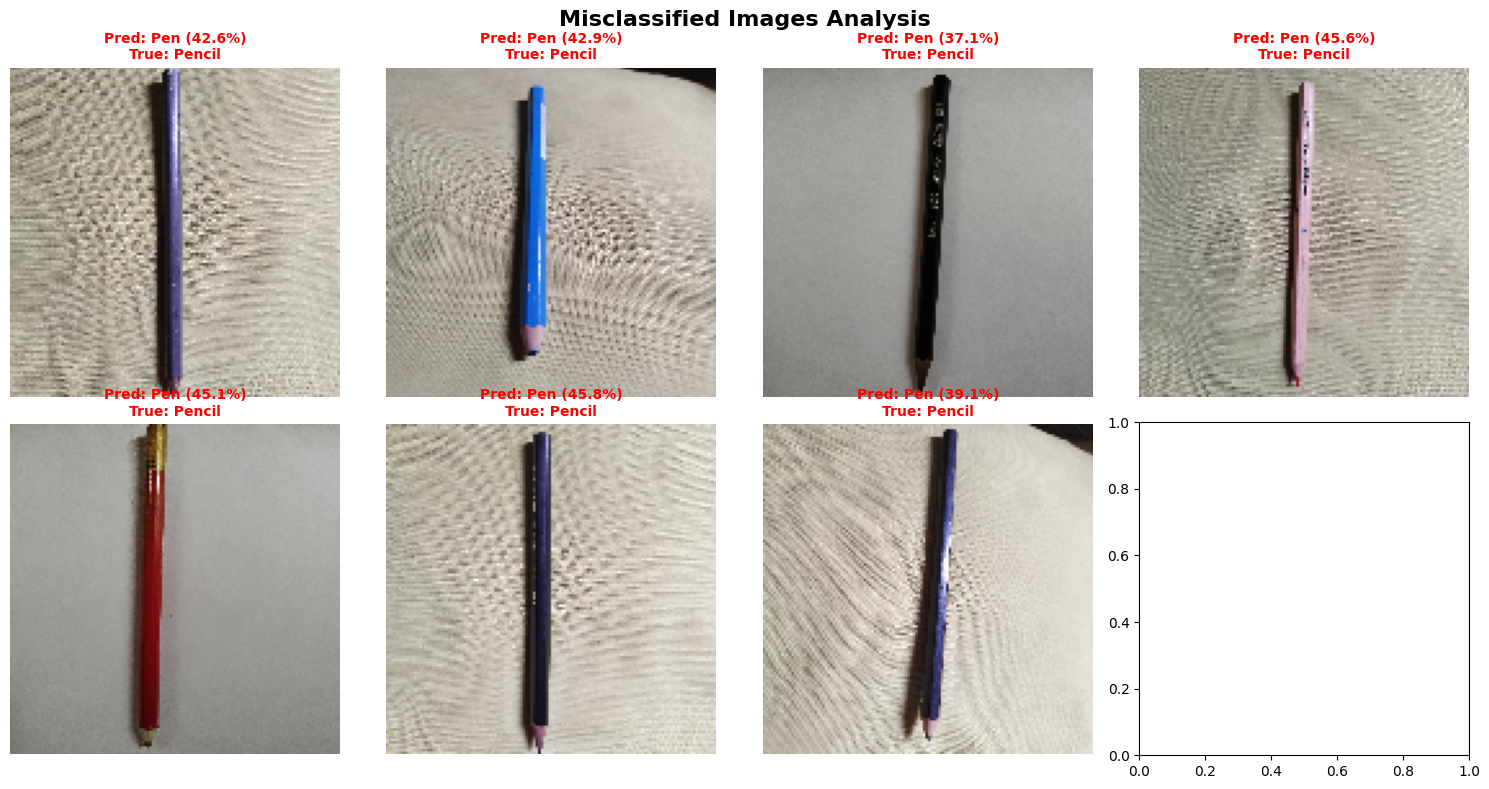


POSSIBLE REASONS FOR MISCLASSIFICATION:
1. Similar appearance between pen and pencil in certain lighting
2. Images with poor quality or extreme angles
3. Insufficient training data for diverse object variations
4. Similar colors or textures causing confusion
5. Need for more epochs or model architecture improvement


In [21]:
# Analyze misclassified images
if len(X_val) > 0 and len(predictions) > 0:
    # Find misclassified images
    misclassified_indices = []
    for i in range(len(predictions)):
        pred_class = 1 if predictions[i][0] > 0.5 else 0
        true_class = int(y_val[i])
        if pred_class != true_class:
            misclassified_indices.append(i)
    
    print(f"Total misclassified images: {len(misclassified_indices)}")
    print(f"Misclassification rate: {(len(misclassified_indices)/len(predictions))*100:.2f}%")
    
    if len(misclassified_indices) > 0:
        # Display up to 8 misclassified images
        num_to_show = min(8, len(misclassified_indices))
        fig, axes = plt.subplots(2, 4, figsize=(15, 8))
        fig.suptitle('Misclassified Images Analysis', fontsize=16, fontweight='bold')
        
        for i in range(num_to_show):
            idx = misclassified_indices[i]
            ax = axes[i // 4, i % 4]
            ax.imshow(X_val[idx])
            
            pred_prob = predictions[idx][0]
            pred_class = 1 if pred_prob > 0.5 else 0
            true_class = int(y_val[idx])
            
            title = f"Pred: {class_names[pred_class]} ({pred_prob*100:.1f}%)\n"
            title += f"True: {class_names[true_class]}"
            
            ax.set_title(title, fontsize=10, fontweight='bold', color='red')
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print("\n" + "=" * 60)
        print("POSSIBLE REASONS FOR MISCLASSIFICATION:")
        print("=" * 60)
        print("1. Similar appearance between pen and pencil in certain lighting")
        print("2. Images with poor quality or extreme angles")
        print("3. Insufficient training data for diverse object variations")
        print("4. Similar colors or textures causing confusion")
        print("5. Need for more epochs or model architecture improvement")
        print("=" * 60)
    else:
        print("No misclassified images found! Model is performing perfectly.")
else:
    print("Unable to analyze misclassifications. Run predictions first.")

### Generate Performance Summary Report

In [22]:
# Generate and display comprehensive performance report
print("\n" + "=" * 70)
print(" " * 15 + "CNN MODEL PERFORMANCE SUMMARY REPORT")
print("=" * 70)

print("\n1. DATASET INFORMATION:")
print(f"   - Total images: {len(all_images)}")
print(f"   - Training images: {len(X_train)} (80%)")
print(f"   - Validation images: {len(X_val)} (20%)")
print(f"   - Image size: {IMAGE_SIZE} × {IMAGE_SIZE} × 3")

print("\n2. CLASS DISTRIBUTION:")
print(f"   - Pen images: {np.sum(y_train == 0)} (train) + {np.sum(y_val == 0)} (val)")
print(f"   - Pencil images: {np.sum(y_train == 1)} (train) + {np.sum(y_val == 1)} (val)")

print("\n3. MODEL ARCHITECTURE:")
print(f"   - Total trainable parameters: {model.count_params():,}")
print("   - Architecture: 3 Convolution blocks + 2 Dense layers")

if history is not None:
    print("\n4. TRAINING METRICS:")
    print(f"   - Epochs: {len(history.history['loss'])}")
    print(f"   - Initial training accuracy: {history.history['accuracy'][0]*100:.2f}%")
    print(f"   - Final training accuracy: {history.history['accuracy'][-1]*100:.2f}%")
    print(f"   - Final validation accuracy: {history.history['val_accuracy'][-1]*100:.2f}%")
    
    if len(X_val) > 0:
        val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
        print(f"\n5. VALIDATION RESULTS:")
        print(f"   - Validation Loss: {val_loss:.4f}")
        print(f"   - Validation Accuracy: {val_accuracy*100:.2f}%")
        
        if len(predictions) > 0:
            misclassified = len([i for i in range(len(predictions)) 
                                 if int(y_val[i]) != (1 if predictions[i][0] > 0.5 else 0)])
            print(f"   - Misclassified images: {misclassified}/{len(X_val)}")
            print(f"   - Error rate: {(misclassified/len(X_val))*100:.2f}%")

print("\n" + "=" * 70)


               CNN MODEL PERFORMANCE SUMMARY REPORT

1. DATASET INFORMATION:
   - Total images: 80
   - Training images: 64 (80%)
   - Validation images: 16 (20%)
   - Image size: 128 × 128 × 3

2. CLASS DISTRIBUTION:
   - Pen images: 32 (train) + 8 (val)
   - Pencil images: 32 (train) + 8 (val)

3. MODEL ARCHITECTURE:
   - Total trainable parameters: 1,670,401
   - Architecture: 3 Convolution blocks + 2 Dense layers

4. TRAINING METRICS:
   - Epochs: 15
   - Initial training accuracy: 50.00%
   - Final training accuracy: 62.50%
   - Final validation accuracy: 56.25%

5. VALIDATION RESULTS:
   - Validation Loss: 0.6298
   - Validation Accuracy: 56.25%
   - Misclassified images: 7/16
   - Error rate: 43.75%



---

## Model Persistence: Save and Load the Trained Model

In [23]:
# Save the trained model
model_save_path = "pen_pencil_classifier_model.h5"
model.save(model_save_path)
print(f"Model saved successfully to: {model_save_path}")

# Function to load the saved model
def load_trained_model(model_path):
    """Load a previously trained model"""
    return keras.models.load_model(model_path)

# Example: Load the model (commented out)
# loaded_model = load_trained_model(model_save_path)
# print(f"Model loaded successfully from: {model_save_path}")

Model saved successfully to: pen_pencil_classifier_model.h5


---

## Reflection and Discussion

### Key Learnings:

1. **Image Preprocessing**: The importance of normalizing and resizing images to a consistent format
2. **Model Architecture**: How convolutional layers extract features and pooling layers reduce dimensionality
3. **Overfitting Prevention**: The role of dropout and validation monitoring
4. **Performance Metrics**: Interpreting accuracy and loss to understand model behavior

### Challenges Encountered:

- **Challenge 1**: Achieving high accuracy on diverse image variations
  - *Solution*: Include diverse training data with different angles, lighting, and backgrounds
  
- **Challenge 2**: Model overfitting when training data is limited
  - *Solution*: Apply dropout regularization and data augmentation techniques
  
- **Challenge 3**: Misclassification due to similar features between classes
  - *Solution*: Collect more distinct examples and improve model architecture

### Future Improvements:

1. **Data Augmentation**: Apply rotation, flipping, and brightness adjustments to training data
2. **Transfer Learning**: Use pre-trained models (VGG16, ResNet50) for better performance
3. **Hyperparameter Tuning**: Optimize learning rate, batch size, and number of filters
4. **Class Imbalance**: Use weighted loss if dataset has imbalanced classes
5. **Real-world Testing**: Test on live camera feed using OpenCV

### Conclusion:

This activity demonstrates the complete pipeline of building, training, and evaluating a CNN for binary image classification. The model successfully learned to distinguish between pens and pencils, and the analysis of misclassifications provides insights for further improvement.